In [1]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from pathlib import Path
from bayes_opt import BayesianOptimization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

In [2]:
data=pd.read_csv('./use_4.csv')
train_data,test_data=train_test_split(data,test_size=0.2,
                                      random_state=1318
                                      )
feature=train_data.drop(['丙烯选择性','Unnamed: 0'],axis=1)
label=train_data['丙烯选择性']

In [3]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [4]:
def XGB_cv(n_estimators,  max_depth):
    val = cross_val_score(
        XGBRegressor(n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            random_state=1314,
            learning_rate=0.1
        ),
        feature, label, scoring='r2', cv=kfold
    ).mean()
    return val

In [5]:
XGB_opt = BayesianOptimization(
        XGB_cv,
        {'n_estimators': (50, 1000),
        'max_depth': (2, 15)}
    )

In [6]:
XGB_opt.maximize(n_iter=50)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.6044    | 5.189     | 758.8     |
| 2         | 0.6036    | 10.4      | 645.3     |
| 3         | 0.5944    | 8.517     | 103.7     |
| 4         | 0.5928    | 12.48     | 813.7     |
| 5         | 0.5978    | 7.489     | 400.3     |
| 6         | 0.6044    | 5.065     | 759.9     |
| 7         | 0.6011    | 6.514     | 690.2     |
| 8         | 0.5432    | 2.892     | 603.8     |
| 9         | 0.5923    | 14.8      | 350.6     |
| 10        | 0.5928    | 12.97     | 447.1     |
| 11        | 0.5923    | 14.95     | 723.2     |
| 12        | 0.5923    | 14.99     | 666.0     |
| 13        | 0.5968    | 7.605     | 152.2     |
| 14        | 0.5923    | 14.44     | 190.2     |
| 15        | 0.5356    | 3.625     | 56.13     |
| 16        | 0.5886    | 3.753     | 868.8     |
| 17        | 0.5275    | 2.425     | 297.1     |
| 18        | 0.5357    | 2.212     | 498.9     |


In [22]:
model = XGBRegressor(n_estimators=300,random_state=1314,booster='gbtree',
                     colsample_bytree=0.56,
                     subsample=0.38,
                     reg_lambda=2,
                     max_depth=6,learning_rate=0.1).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.6459935464068528
rmse: 12.025054256481605


In [23]:
test_x = test_data.drop(['丙烯选择性','Unnamed: 0'],axis=1)
test_y = test_data['丙烯选择性']
test_score = model.score(test_x,test_y)
print('测试集得分为：', test_score)

测试集得分为： 0.6053427801995234


In [24]:
# 预测1
Y1=model.predict(X=test_data.drop(['丙烯选择性','Unnamed: 0'],axis=1))
Y2=test_data['丙烯选择性']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [25]:
# 预测2
Y_1=model.predict(X=feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

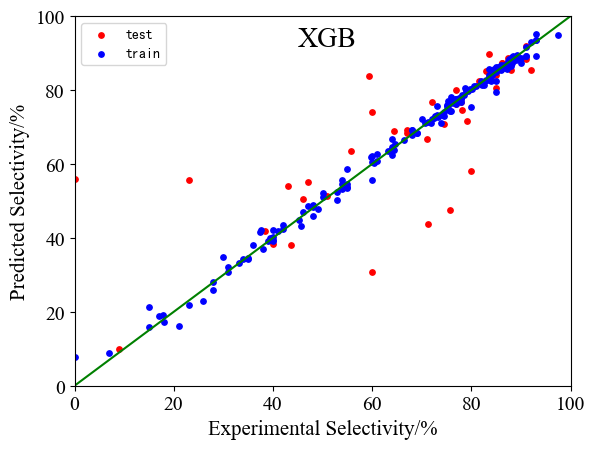

In [27]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,100))
plt.xlabel('Experimental Selectivity/%',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,100))
plt.ylabel('Predicted Selectivity/%',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,100],[0,100],color='g')
plt.text(45,92,'XGB',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()